<b>Data Sources</b>
* Data on parcels from [San Bernardino Open Data Portal](https://open.sbcounty.gov/datasets/countywide-parcels/about) and <>INSERT SOURCE FOR RIVERSIDE HERE<>
* Shapefiles for National Highway Freight Network from [Federal Highway Administration ](https://fpcb.ops.fhwa.dot.gov/tools_nhfn.aspx)
* Data on warehouse locations and year built from [Warehouse CITY](https://radicalresearch.shinyapps.io/WarehouseCITY)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

<b>Part 1: Merge Assessor Parcels Together</b>

Import Riverside data and clean it up so that it matches San Bernardino data

In [ ]:
# import data for all parcels in Riverside County
riverside = gpd.read_file('riversideparcels/riversideparcels.shp')
# set APN to be the index
riverside.set_index('APN',inplace=True)
# drop unneccessary columns
riverside=riverside[['landval','geometry']]
# rename columns to match san bernardino parcels
riverside.rename(columns={'landval':'LAND_VALUE'},inplace=True)
# check if APN is unique
print(riverside.index.is_unique)
riverside.head(5)

Import San Bernardino data and clean it up so that it matches Riverside data

In [ ]:
# import data for all parcels in San Bernadino County downloaded from https://open.sbcounty.gov/datasets/countywide-parcels/about.
sanbernardino = gpd.read_file('data/countywide_parcels/pbmpoly.shp')
# keep just columns we need to reduce file size
sanbernardino=sanbernardino[['APN','LAND_VALUE', 'geometry']]
# set APN to be the index
sanbernardino.set_index('APN',inplace=True)
# check that it is unique
sanbernardino.index.is_unique

In [4]:
# dissolve parcel subdivisions
sanbernardino = sanbernardino.dissolve(by='APN',aggfunc={"LAND_VALUE": 'sum'})
print(sanbernardino.index.is_unique)
sanbernardino.head()

True


geometry  LAND_VALUE
APN                                                                     
0          MULTIPOLYGON (((6685412.278 1820763.726, 66854...         0.0
000000000  MULTIPOLYGON (((6692866.784 1825606.796, 66928...         0.0
010829107  POLYGON ((6675457.139 1853449.721, 6676118.522...         0.0
010829113  POLYGON ((6676118.522 1853450.723, 6676250.489...         0.0
010829114  POLYGON ((6676250.489 1853450.923, 6676382.774...         0.0

Concatenate the two datasets!

In [5]:
# riverside and san bernardino have different projections, but we're going to go with san bernardino (2229) because it's the same as LA County
riverside=riverside.to_crs(2229)
# concatenate
parcels = pd.concat([riverside, sanbernardino])
parcels.head()

LAND_VALUE                                           geometry
APN                                                                     
101160001      1612.0  POLYGON ((6674568.907 1783470.301, 6674524.894...
101200001     33813.0  POLYGON ((6662851.827 1773920.818, 6662839.230...
101200010      4751.0  POLYGON ((6662442.801 1773254.898, 6662382.825...
101200011      7803.0  POLYGON ((6662502.778 1773256.955, 6662452.737...
101160002      1048.0  POLYGON ((6675124.095 1783430.288, 6674931.544...

In [6]:
print(len(riverside)+len(sanbernardino)==len(parcels))

True


<b>Part 2: Calculate Distance to Freight</b><br>
Here we use shapefiles of the locations of the National Highway Freight Network to calculate the distance from each parcel to the network.

In [7]:
freight = gpd.read_file('data/NHFN_GIS_Shapefiles_Jan_2022/PublicRelease/National-NHFN-2022.shp')
# Keep just columns we need to reduce file size.
freight=freight[['NHFN_CODE','geometry']]
# join info about nearest freight route to each parcel 
parcels = gpd.sjoin_nearest(parcels, freight.to_crs(2229), how='left',rsuffix='freight',distance_col="distances",max_distance=400000)

Text(0.5, 1.0, 'Distance to National Highway Freight Network')

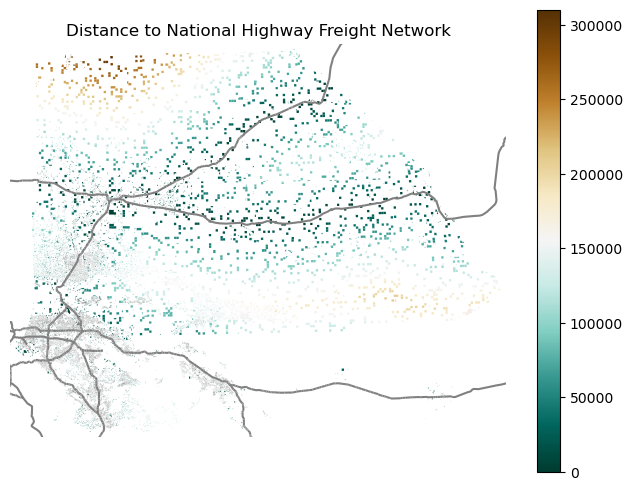

In [8]:
# plot 10% of parcels (to reduce drawing time) to make sure results seem reasonable
minx, miny, maxx, maxy = parcels.geometry.total_bounds
fig, ax = plt.subplots(figsize=(8, 6))
parcels.sample(frac=0.1).plot(ax=ax,column='distances',legend=True,cmap='BrBG_r')
freight.to_crs(2229).plot(ax=ax,color='grey')
ax.axis('off')
ax.set_xlim(minx-10000,maxx+10000)
ax.set_ylim(miny-10000,maxy+10000)
ax.set_title('Distance to National Highway Freight Network')
#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

<b>Part 3: Determine Presence of Warehouses</b>

In [9]:
# import warehouse data downloaded from Warehouse City (https://radicalresearch.shinyapps.io/WarehouseCITY/)
warehouses = pd.read_csv('data/Warehouse_List.csv')

# rename columnn names so that they don't have spaces and are easier to work with
warehouses.rename(columns={'Assessor parcel number':'APN','Building classification':'building_class','Year built':'year',
                           'Acres':'acres','Building sq.ft.':'sqft'},inplace=True)
warehouses.head()

Category                                      APN  \
0  Planned and Approved                   World Logistics Center   
1  Planned and Approved  Legacy Highlands Phase II Specific Plan   
2  Planned and Approved       Airport Gateway Specific Plan Area   
3  Planned and Approved               Stoneridge Commerce Center   
4  Planned and Approved                 Speedway Commerce Center   

  building_class  year  acres      sqft  
0            TBD  2025   2650  63499000  
1            TBD  2025   1386  33207000  
2            TBD  2025    613  14689000  
3            TBD  2025    606  14523000  
4            TBD  2025    464  11118000

Between the simple maps above and some additional research in the [County Zoning District Maps](https://sbcounty.maps.arcgis.com/apps/MapSeries/index.html?appid=f5a50c44766b4c36a3ae014497aa430d) we have confirmed that the duplicated Assessor Numbers are associated with parcels with multiple subdivisions with warehouses on them. We want our analysis to take place at the parcel level, so we will aggregate our data accordingly.

In [10]:
# get category and buiding class associated with each parcel.
warehouse_parcels=warehouses.groupby('APN')[['Category','building_class']].first()
# get first year that a warehouse was built on the parcel.
year=warehouses.groupby('APN')[['year']].min()
# get total acres of warehouses built on the parcel.
area=warehouses.groupby('APN')[['acres','sqft']].sum()
# get number of warehouses
num_warehouses=warehouses.groupby('APN').size()
num_warehouses.name='num_warehouses'
# join all of these column together on parcel_id.
warehouse_parcels=warehouse_parcels.join(year).join(area).join(num_warehouses)
warehouse_parcels.sample(5)

Category  \
APN                                          
028104136                         Existing   
8168-027-401                      Existing   
8533-011-045                      Existing   
3271-027-047                      Existing   
1400S Allec St Anaheim, CA 92805  Existing   

                                                      building_class  year  \
APN                                                                          
028104136                                           light industrial  1980   
8168-027-401                      Warehousing, Distribution, Storage  1990   
8533-011-045                      Warehousing, Distribution, Storage  1984   
3271-027-047                      Warehousing, Distribution, Storage  2001   
1400S Allec St Anaheim, CA 92805                           warehouse  1980   

                                  acres    sqft  num_warehouses  
APN                                                              
028104136                             6  141000               1  
8168-027-401                          2   55000               1  
8533-011-045                          4  101000               1  
3271-027-047                         10  248000               1  
1400S Allec St Anaheim, CA 92805      5  128000               1

In [11]:
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020.
warehouse_parcels['warehouse_2010']=warehouse_parcels.year.apply(lambda x: True if x<=2010 else False)
warehouse_parcels['warehouse_2020']=warehouse_parcels.year.apply(lambda x: True if x<=2020 else False)
warehouse_parcels['built_2010s']=warehouse_parcels.year.apply(lambda x: True if (2010 <= x <= 2020) else False)
# check to see that this has worked.
warehouse_parcels.sample(5)

Category                      building_class  year  acres  \
APN                                                                       
8059-005-050  Existing  Warehousing, Distribution, Storage  1987      1   
045946144     Existing                    light industrial  2004     10   
2761-001-066  Existing  Warehousing, Distribution, Storage  1982      2   
115090023     Existing                    light industrial  1980      4   
8760-024-052  Existing  Warehousing, Distribution, Storage  1998      3   

                sqft  num_warehouses  warehouse_2010  warehouse_2020  \
APN                                                                    
8059-005-050   35000               1            True            True   
045946144     245000               1            True            True   
2761-001-066   52000               1            True            True   
115090023     101000               1            True            True   
8760-024-052   80000               1            True            True   

              built_2010s  
APN                        
8059-005-050        False  
045946144           False  
2761-001-066        False  
115090023           False  
8760-024-052        False

In [12]:
# join info about presence of warehouses to the parcel data
parcels_warehouses=parcels.join(warehouse_parcels,how='left')

Map to ensure that this looks like Warehouse City (map below is screenshot)

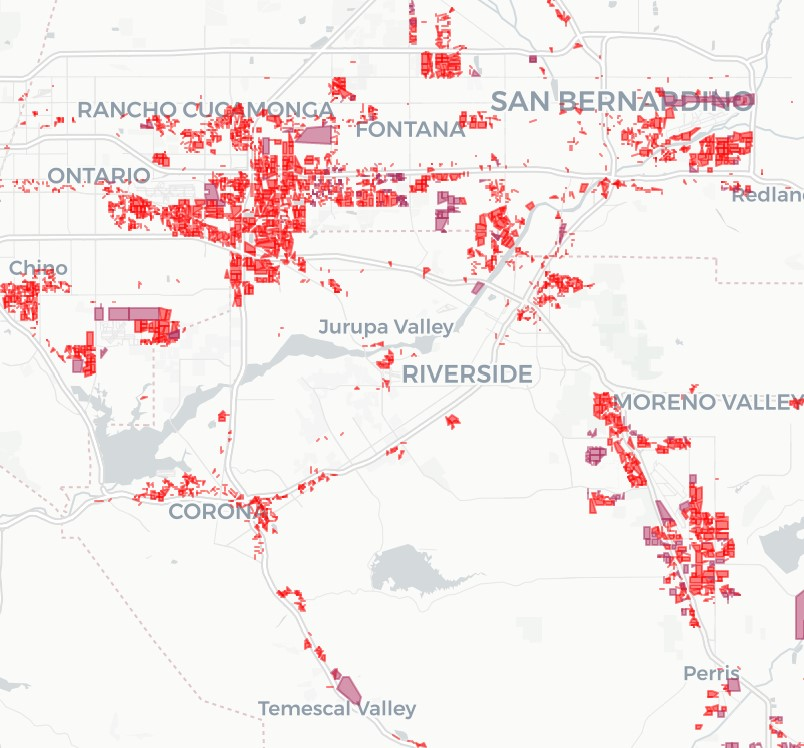

In [13]:
counties=gpd.read_file('data/CA_Counties/CA_Counties_TIGER2016.shp')
counties=counties[counties.NAME.apply(lambda x: True if x in ('Riverside','San Bernardino') else False)]

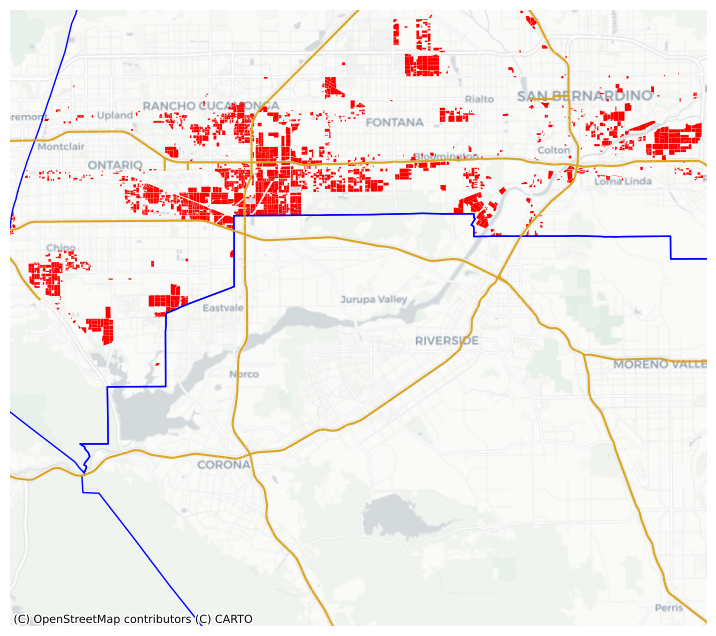

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
parcels_warehouses[parcels_warehouses['num_warehouses']>0].plot(ax=ax,color='red')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
counties.plot(ax=ax,color='none')
counties.to_crs(2229).plot(ax=ax,color='none',edgecolor='blue')
ax.axis('off')
ax.set_xlim(6643710, 6804764)
ax.set_ylim(1740000,1882403)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

San Bernardino is looking pretty good, but it looks like there are no warehouses in Riverside which we know isn't true :( 
To start troubleshooting, I used the [Riverside Assessor Database](https://ca-riverside-acr.publicaccessnow.com/Search.aspx?s=156030048&pg=1&g=-1&moduleId=478) to search for some three parcels that I knew were 1) in Riverside County, and 2) had warehouses on them (found examples on Warehouse CITY website). All three of these did return matches on the Riverside Assessor Database but are missing from the Riverside parcel data:
* 156030029 
* 156030046
* 156030048

This means that these parcels got lost somewhere earlier in the process that when I uploaded them into this notebook :(

In [15]:
# even though this has to change i'm gonna save it 
parcels_warehouses.to_file('data/parcels_warehouses.geojson')